---

<div class="alert alert-block alert-success">
    
# Исследование объявлений о продаже квартир в СПб и области
    
</div 

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
data = pd.read_csv('real_estate_data.csv',sep='\t')

# Шаг 1. Ознакомимся с нашим датасетом

In [125]:
print(data)

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0                2.70 

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В датасете 22 колонки и 23699 строк, данные разного формата: целые числа, числа с плавающей точкой, строковые значения, булев тип. Есть пропуски в данных

Построим общую гистограмму для всех числовых столбцов таблицы

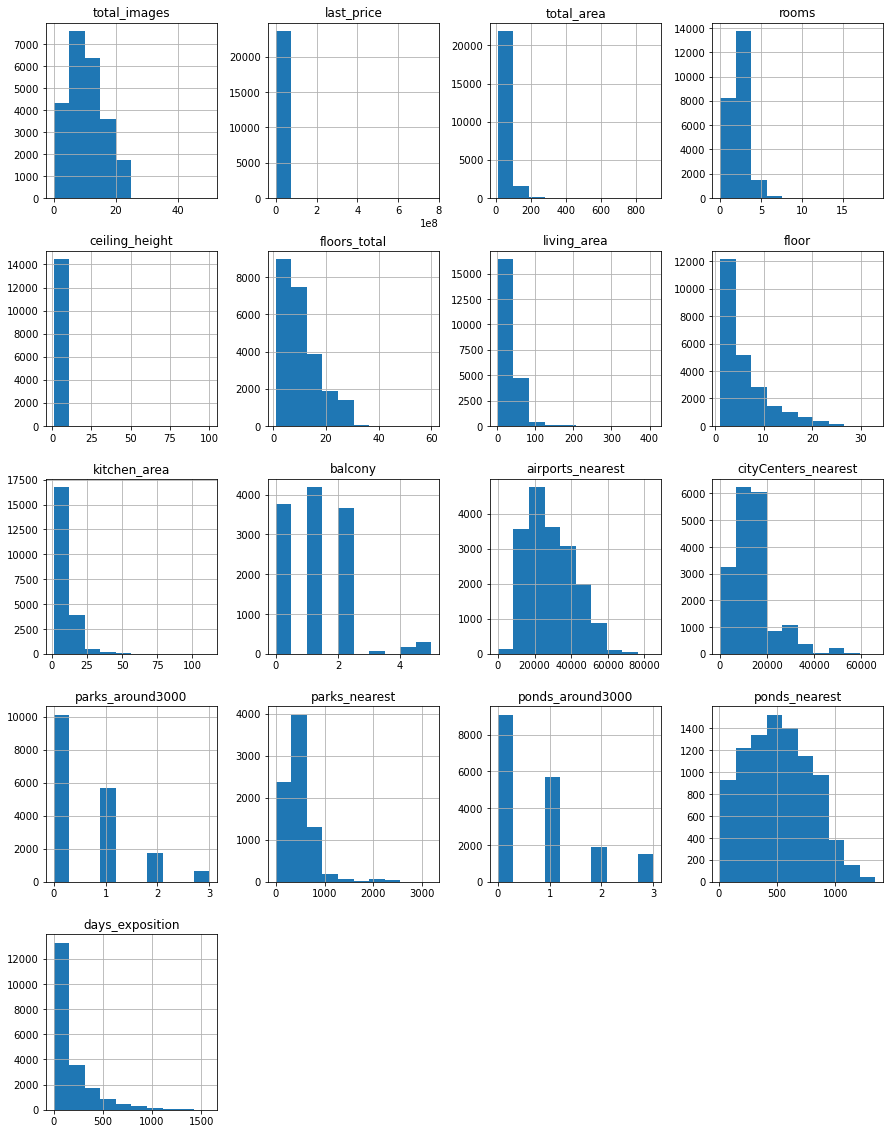

In [127]:
data.hist(figsize=(15, 20))
plt.show()

На первый взгляд подозрительно выглядят столбцы: 
- last_price, 
- ceiling_height - много пропущенных значений, это видно уже по графику, 
- balcony - бывает ли 3, 4 и даже 5 балконов?
- living_area - жилая площадь, равная 0 квадратам? Странно

# Шаг 2. Предобработка данных

### 2.1.Найдем и изучим пропущенные значения в столбцах

Посчитаем. сколько строк из всего датасета содержат пропущенные значения:

In [128]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Данные пропущены в:**
- ceiling_height - нужно разбираться, 
- floors_total - пропуски, вероятно, из-за того, что не указали количество этажей. Здесь целесообразно оставить эти пропуски,
- living_area - 
- kitchen_area - оставим Null
- is_apartment - многие квартиры не являются апартаментами (поэтому может быть указан не False, а просто пропуск в данных),
- balcony - есть квартиры без балконов (там может быть не указано число 0, а просто пропущены значения), 
- locality_name - пропуски в названиях можно заполнить только значением 'unknown',
- airports_nearest - данные не указаны при размещении объявления, можно заменить медианой по конкретным населенным пунктам,
- cityCenters_nearest - или оставляем Null, или заполняем медианой по группам населенных пунктов (решим позже),
- parks_nearest - поблизости просто нет парков, ноль исказит данные, поэтому оставим NaN
- ponds_nearest - поблизости нет водоемов. Уже при первом рассмотрении датасета заметна зависимость у parks_around3000 и parks_nearest - где в радиусе 3000 км нет парков, там в расстоянии до ближайшего парка стоит 0 или пропущено значение (аналогичная ситуация с ponds_around3000 и ponds_nearest). Оставляем NaN,
- в parks_around3000 и ponds_around3000 можем заменить пропуски на 0,
- days_exposition - возможно, объявление не публиковалось или техниеский сбой

In [129]:
print(data[['ponds_around3000', 'ponds_nearest']].head(20))

    ponds_around3000  ponds_nearest
0                2.0          755.0
1                0.0            NaN
2                2.0          574.0
3                3.0          234.0
4                1.0           48.0
5                NaN            NaN
6                0.0            NaN
7                0.0            NaN
8                NaN            NaN
9                0.0            NaN
10               2.0          553.0
11               0.0            NaN
12               NaN            NaN
13               3.0          298.0
14               1.0           96.0
15               1.0          296.0
16               0.0            NaN
17               1.0          859.0
18               0.0            NaN
19               0.0            NaN


In [130]:
print(data[['ponds_around3000', 'ponds_nearest']].isnull())

       ponds_around3000  ponds_nearest
0                 False          False
1                 False           True
2                 False          False
3                 False          False
4                 False          False
...                 ...            ...
23694             False          False
23695              True           True
23696              True           True
23697             False          False
23698              True           True

[23699 rows x 2 columns]


In [131]:
print(data[['parks_around3000', 'parks_nearest']].head(20))

    parks_around3000  parks_nearest
0                1.0          482.0
1                0.0            NaN
2                1.0           90.0
3                2.0           84.0
4                2.0          112.0
5                NaN            NaN
6                0.0            NaN
7                0.0            NaN
8                NaN            NaN
9                0.0            NaN
10               1.0          310.0
11               0.0            NaN
12               NaN            NaN
13               1.0          294.0
14               0.0            NaN
15               1.0          590.0
16               3.0          420.0
17               0.0            NaN
18               1.0          759.0
19               0.0            NaN


<div class="alert alert-block alert-success">
Гипотеза по поводу парков и водоемов подтверждается. Можем заменить отсутствующие данные в этих столбцах на 0 (только не исказят ли эти нули данные с расстоянием в метрах?) Поэтому в parks_nearest и в ponds_nearest оставим пропущенные значения.

In [132]:
data[['balcony', 'parks_around3000', 'ponds_around3000']] = data[['balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)

In [133]:
print(data[['balcony', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].head(20))

    balcony  parks_around3000  parks_nearest  ponds_around3000  ponds_nearest
0       0.0               1.0          482.0               2.0          755.0
1       2.0               0.0            NaN               0.0            NaN
2       0.0               1.0           90.0               2.0          574.0
3       0.0               2.0           84.0               3.0          234.0
4       0.0               2.0          112.0               1.0           48.0
5       0.0               0.0            NaN               0.0            NaN
6       1.0               0.0            NaN               0.0            NaN
7       2.0               0.0            NaN               0.0            NaN
8       0.0               0.0            NaN               0.0            NaN
9       2.0               0.0            NaN               0.0            NaN
10      0.0               1.0          310.0               2.0          553.0
11      1.0               0.0            NaN               0.0  

Пропуски в данных по количеству балконов, паркам и водоемам заполнены нулями

<div class="alert alert-block alert-warning">
Со столбцом 'is_apartment', скорее всего, аналогичная ситуация как с 'balcony' - там, где не указаны данные, подразумевает под собой значение False (квартира не является апартаментами), пользователь просто пропустил и не указал значение в данной характеристике, так как ему это незачем.
Заменим пропущенные значение в данном столбце на 'False'.

In [134]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Тип данных должен автоматически поменяться с object на нужный нам bool

### 2.2. Рассмотрим типы данных в каждом столбце

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

first_day_exposition - это дата в формате ISO, значит необходимо перевести столбец в формат даты. В строках также не указаны часы и секунды - вместо них нули, значит, можем избавиться и от них

In [136]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [137]:
print(data['first_day_exposition'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]


In [138]:
print(data['first_day_exposition'].min())

2014-11-27 00:00:00


In [139]:
print(data['first_day_exposition'].max())

2019-05-03 00:00:00


Самые первые данные датированы 27 ноября 2014 года, а самые последние - 3 мая 2019 года. Итого: данные собраны за 4 с половиной года

In [140]:
#Создадим столбец с округленными до дня датами публикации:
data['first_day_rounded'] = data['first_day_exposition'].dt.round('1d')

In [141]:
print(data['first_day_rounded'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_rounded, Length: 23699, dtype: datetime64[ns]


Приведем last_price  к типу int

In [142]:
data['last_price'] = data['last_price'].astype('int32')


In [143]:
#Создадим столбец с ценой в тысячах рублей
data['last_price_th'] = data['last_price'] * 0.001
data['last_price_th'] = data['last_price_th'].astype('int32')
print(data['last_price_th'].head())

0    13000
1     3350
2     5196
3    64900
4    10000
Name: last_price_th, dtype: int32


### 2.3. Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты

In [144]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [145]:
data['locality_name2'] = data['locality_name'].str.lower()
print(data['locality_name2'])

0            санкт-петербург
1             посёлок шушары
2            санкт-петербург
3            санкт-петербург
4            санкт-петербург
                ...         
23694        санкт-петербург
23695                  тосно
23696       село рождествено
23697        санкт-петербург
23698    поселок новый учхоз
Name: locality_name2, Length: 23699, dtype: object


In [146]:
print(data['locality_name2'].value_counts())

санкт-петербург                    15721
посёлок мурино                       522
посёлок шушары                       440
всеволожск                           398
пушкин                               369
                                   ...  
поселок каложицы                       1
посёлок платформа 69-й километр        1
поселок почап                          1
поселок гончарово                      1
посёлок дзержинского                   1
Name: locality_name2, Length: 364, dtype: int64


In [147]:
data['locality_name2'] = data['locality_name2'].str.replace('посёлок','поселок')

In [148]:
data['locality_name2'] = data['locality_name2'].str.replace('городской поселок','поселок городского типа')

In [149]:
data['locality_name2'] = data['locality_name2'].str.replace('городской посёлок','поселок городского типа')
data['locality_name2'] = data['locality_name2'].str.replace('посёлок городского типа','поселок городского типа')

In [150]:
#data['locality_name2'] = data['locality_name2'].str.replace('городской поселок','поселок')
#в данном случае, поселок и ПГТ - это, скорее всего, разные типы населенных пунктов

In [151]:
print(data['locality_name2'].value_counts())

санкт-петербург                                      15721
поселок мурино                                         556
поселок шушары                                         440
всеволожск                                             398
пушкин                                                 369
                                                     ...  
поселок цвылёво                                          1
поселок тёсово-4                                         1
поселок при железнодорожной станции приветнинское        1
поселок гладкое                                          1
поселок дзержинского                                     1
Name: locality_name2, Length: 323, dtype: int64


<div class="alert alert-block alert-warning">
Мы избавились от неявных дубликатов в названиях населённых пунктов, при этом создав новый столбец 'locality_name2' 

### 2.4. Поиск и устранение редких и выбивающихся значений

Изучим значения в 'ceiling_height' - высоте потолков

In [152]:
print(data['ceiling_height'])

0        2.70
1         NaN
2         NaN
3         NaN
4        3.03
         ... 
23694    3.70
23695     NaN
23696     NaN
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64


<AxesSubplot:>

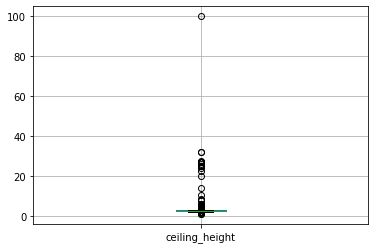

In [153]:
ceiling = pd.DataFrame(data['ceiling_height'])
ceiling.boxplot()

Уже на данном графике мы видим выбивающиеся значения, равные 100 метрам и выше 3 метров (вплоть до 35 м)

In [154]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Минимальное значение равно 1м - слишком мало, максимальное равно 100 м - слишком много, 50% данных находятся в диапазоне до 2.65 м, 75% - в диапазоне до 2.8 м.

In [155]:
print(data['ceiling_height'].sort_values().head(10))


22590    1.00
5712     1.20
16934    1.75
2572     2.00
19329    2.00
11352    2.00
5850     2.00
19098    2.00
16884    2.00
22960    2.00
Name: ceiling_height, dtype: float64


1 м и 1.2 м выглядят неправдоподобно

In [156]:
print(data['ceiling_height'].sort_values(ascending = False).head(20))

22869    100.0
22336     32.0
3148      32.0
21377     27.5
20478     27.0
5246      27.0
5807      27.0
10773     27.0
17857     27.0
22938     27.0
21824     27.0
4876      27.0
5669      26.0
18545     25.0
11285     25.0
355       25.0
6246      25.0
14382     25.0
4643      25.0
9379      25.0
Name: ceiling_height, dtype: float64


In [157]:
print(data.query('ceiling_height == 100.0'))

       total_images  last_price  total_area first_day_exposition  rooms  \
22869             0    15000000        25.0           2018-07-25      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
22869           100.0           5.0         14.0      5          True  ...   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
22869           34963.0               8283.0               1.0          223.0   

      ponds_around3000  ponds_nearest  days_exposition  first_day_rounded  \
22869              3.0           30.0             19.0         2018-07-25   

       last_price_th   locality_name2  
22869          15000  санкт-петербург  

[1 rows x 25 columns]


всего 1 строка со значением высоты потолка равным 100 м. Избавление от нее не повлияет на результаты анализа. А вот с двузначными значениями нужно поработать

In [158]:
data = data.drop(index=22869)

<AxesSubplot:>

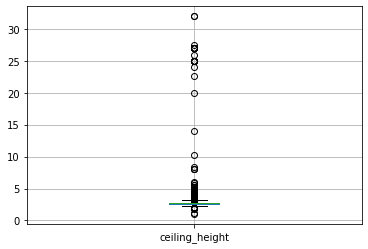

In [159]:
ceiling = pd.DataFrame(data['ceiling_height'])
ceiling.boxplot()

На данный момент высота от потолка до пола в РФ регламентируется в соответствии со СНиПом от 2003 года. 
Если упростить, то получается следующая система:
- Если температура зимой может опускаться ниже -30 по Цельсию, то минимальная высота — 2,7 м.
- Во всех остальных регионах нормой считается потолок от 2,5 м.

In [160]:
data.query('ceiling_height >= 25.0 & ceiling_height <= 36') 
#print(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_rounded,last_price_th,locality_name2
355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,NaN,0.0,NaN,0.0,NaN,259.0,2018-07-12,3600,гатчина
3148,14,2900000,75.0,2018-11-12,3,32.0,3.0,53.0,2,False,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2018-11-12,2900,волхов
4643,0,4300000,45.0,2018-02-01,2,25.0,9.0,30.0,2,False,...,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0,2018-02-01,4300,санкт-петербург
4876,7,3000000,25.0,2017-09-27,0,27.0,25.0,17.0,17,False,...,NaN,NaN,0.0,NaN,0.0,NaN,28.0,2017-09-27,3000,поселок мурино
5246,0,2500000,54.0,2017-10-13,2,27.0,5.0,30.0,3,False,...,NaN,NaN,0.0,NaN,0.0,NaN,540.0,2017-10-13,2500,деревня мины
5669,4,4400000,50.0,2017-08-08,2,26.0,9.0,21.3,3,False,...,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0,2017-08-08,4400,санкт-петербург
5807,17,8150000,80.0,2019-01-09,2,27.0,36.0,41.0,13,False,...,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,2019-01-09,8150,санкт-петербург
6246,6,3300000,44.4,2019-03-25,2,25.0,5.0,31.3,5,False,...,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN,2019-03-25,3300,кронштадт
9379,5,3950000,42.0,2017-03-26,3,25.0,5.0,30.0,2,False,...,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN,2017-03-26,3950,санкт-петербург
10773,8,3800000,58.0,2017-10-13,2,27.0,10.0,30.1,3,False,...,NaN,NaN,0.0,NaN,0.0,NaN,71.0,2017-10-13,3800,поселок мурино


**У квартир с высотой потолков до 25 до 36 метров можно предположить, что это опечатка. Поэтому делим на 10, получая 2.5 и 3.6 метра.**

In [161]:
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

In [162]:
print(data['ceiling_height'])

0        2.70
1         NaN
2         NaN
3         NaN
4        3.03
         ... 
23694    3.70
23695     NaN
23696     NaN
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23698, dtype: float64


**Посмотрим, сколько унас вообще квартир с разной высотой потолков:**

In [163]:
print('Квартир с потолками от 1 м до 2.5 м: ' + str(data.query('ceiling_height >= 1 and ceiling_height <2.5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 2.5 м до 3.6 м: ' + str(data.query('ceiling_height >= 2.5 and ceiling_height <= 3.6')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 4 м до 5 м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 50 м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

Квартир с потолками от 1 м до 2.5 м: 73 шт.
Квартир с потолками от 2.5 м до 3.6 м: 14224 шт.
Квартир с потолками от 4 м до 5 м: 39 шт.
Квартир с потолками от 50 м: 0 шт.


Квартир с потолками ниже 2.5 м и выше 3.6 м не так много, поэтому можем посчитать их выбросами и удалить

In [164]:
data.drop(index=data.query('ceiling_height > 3.6 and ceiling_height < 2.5').index,inplace=True)

In [165]:
print(data.query('ceiling_height > 3.6')['ceiling_height'])

154      4.15
179      4.00
368      3.70
464      5.20
797      3.80
         ... 
22965    4.00
23014    3.70
23330    3.80
23382    3.67
23694    3.70
Name: ceiling_height, Length: 206, dtype: float64


In [166]:
data.drop(index=data.query('ceiling_height > 3.6').index,inplace=True)
print(data.query('ceiling_height > 3.6')['ceiling_height'])

Series([], Name: ceiling_height, dtype: float64)


array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

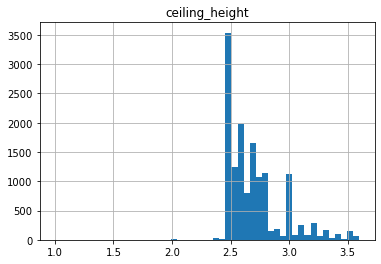

In [167]:
data.hist('ceiling_height',bins=50)

некоторые записи с высотой потолков ниже 2.5 остались - удаляем

In [168]:
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

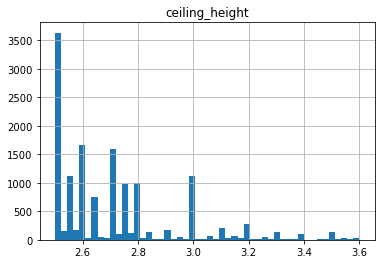

In [169]:
data.hist('ceiling_height',bins=50)

In [170]:
data['ceiling_height'].isna().sum()

9195

**У нас осталось 9179 строк с пропусками в 'ceiling_height'. Целесообразно заменить пропуски высоты потолков на медианные значения по каждому населенному пункту**

In [171]:
median_ceiling_height = data.pivot_table(index='locality_name', values='ceiling_height', aggfunc='median')
median_ceiling_height

,ceiling_height
locality_name,
Бокситогорск,2.80
Волосово,2.50
Волхов,2.58
Всеволожск,2.70
Выборг,2.55
...,...
садовое товарищество Рахья,2.60
село Копорье,2.50
село Павлово,2.75


In [172]:
#С помощью цикла заеним пропуски в высоте потолков на медианные значения по конкретному населенному пункту
for t in data['locality_name'].unique():
    data.loc[(data['locality_name'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['locality_name'] == t), 'ceiling_height'].median()

In [173]:
data['ceiling_height'].isna().sum()

156

Рассмотрим living_area 

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

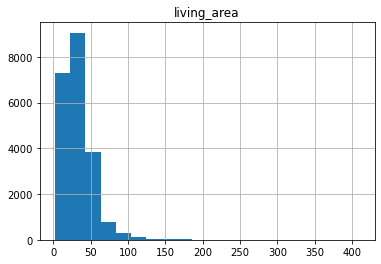

In [174]:
data.hist('living_area',bins=20)

В датасете присутствуют малые значения в 'living_area' - от 0 до 25 кв.м.

In [175]:
print(data.query('living_area < 25')['living_area'])

1        18.60
5        14.40
6        10.60
8        15.43
10       20.30
         ...  
23686    18.00
23687    20.00
23689    16.30
23692    17.50
23698    12.30
Name: living_area, Length: 7606, dtype: float64


In [176]:
less_living_area = data.query('living_area < 25')['living_area']

1        18.60
5        14.40
6        10.60
8        15.43
10       20.30
         ...  
23686    18.00
23687    20.00
23689    16.30
23692    17.50
23698    12.30
Name: living_area, Length: 7606, dtype: float64


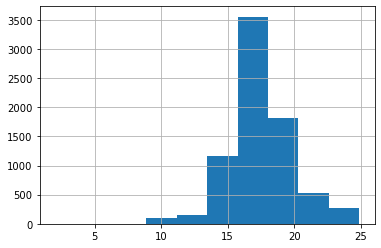

In [177]:
less_living_area.hist()
print(less_living_area)

Есть жилая площадь и менее 10 кв.м

In [178]:
big_living_area = data.query('living_area > 150')['living_area']
print(big_living_area)

155      183.0
660      312.5
681      180.0
793      250.0
813      160.0
         ...  
22835    180.0
22904    159.6
22907    200.0
23005    181.8
23400    151.4
Name: living_area, Length: 97, dtype: float64


<AxesSubplot:>

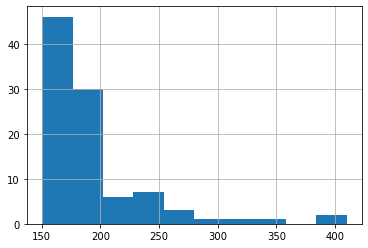

In [179]:
big_living_area.hist()

В нашем датасете присутствуют квартиры с жилой площадью и более 200, и 250, и более 300, и даже равные и больше 400. Их небольшое количество

In [180]:
print('Жилая площадь менее 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь более 200 кв.м.: ',data.query('living_area > 200')['living_area'].count())

Жилая площадь менее 10 кв.м.:  25
Жилая площадь более 200 кв.м.:  21


In [181]:
# Можем удалить значения менее 10 и более 200 кв.м
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

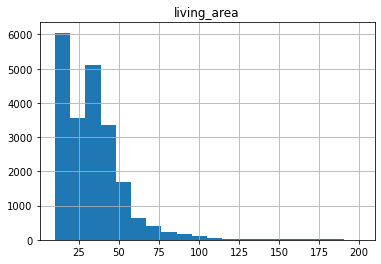

In [182]:
data.hist('living_area',bins=20)

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

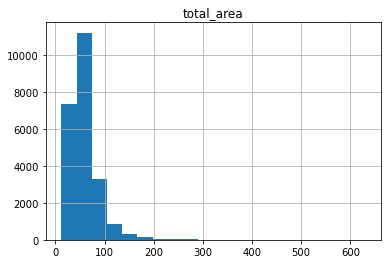

In [183]:
data.hist('total_area',bins=20)

<div class="alert alert-block alert-warning">
Отетим, что общая площадь не должна быть меньше жилой

In [184]:
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())

Жилая площадь больше общей:  0


Таких квартир нет

**Посчитаем пропущенные значения в living_area**

In [185]:
data['living_area'].isna().sum()

1885

Пропуски living_area можно заполнить, исходя из средней пропорции жилой площади к общей площади

In [186]:
proportion_living_area = (data['living_area'] / data['total_area']).median()
data['living_area'] = data['living_area'].fillna(data['total_area']*proportion_living_area)

In [187]:
data['living_area'].isna().sum()

0

**Изучим данные по балконам**

In [188]:
print('Нет балконов:', data.query('balcony == 0')['balcony'].count())
print('1 балкон:', data.query('balcony == 1')['balcony'].count())
print('2 балкона:', data.query('balcony == 2')['balcony'].count())
print('3 балкона:', data.query('balcony == 3')['balcony'].count())
print('4 балкона:', data.query('balcony == 4')['balcony'].count())
print('5 балконов:', data.query('balcony == 5')['balcony'].count())

Нет балконов: 15042
1 балкон: 4137
2 балкона: 3635
3 балкона: 78
4 балкона: 182
5 балконов: 299


In [189]:
data.pivot_table(index='balcony',values='last_price' ,aggfunc = 'count')

,last_price
balcony,
0.0,15042
1.0,4137
2.0,3635
3.0,78
4.0,182
5.0,299


In [190]:
balcony_5 = data.query('balcony == 5')['rooms']

<AxesSubplot:>

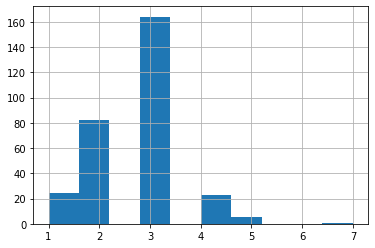

In [191]:
balcony_5.hist()

<div class="alert alert-block alert-warning">
Однокомнатные и двухкомнатные квартиры не могут иметь 5 балконов, а тем более 7, от этих данных точно можно избавиться, но правильнее их будет заполнить медианными значениями. Чаще всего 5 балконов уазано у 3-х комнатных квартир.


**Пропуски в названиях населенных пунков 'locality_name' мы никак не в состоянии заполнить, кроме как значением 'unknown'. В ином случае (при удалении) мы просто потеряем данные**

In [192]:
data['locality_name'] = data['locality_name'].fillna('unknown')

**Посмотрим, сколько пропусков в airports_nearest**

In [193]:
data['airports_nearest'].isna().sum()

5495

Скорее всего пропуски связаны с тем,  что данные по расстоянию до аэропорта просто не указали при размещении объявления.
В данном случае целесообразно будет заполнить пропуски медианным значением для каждого населенного пункта

In [194]:
# Создадим сводную таблицу с медианными значениями по каждому населенному пункту
airports_nearest_median = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median')
print(airports_nearest_median.head(20))


                         airports_nearest
locality_name                            
unknown                           22669.0
Зеленогорск                       72282.0
Колпино                           26232.0
Красное Село                      25723.5
Кронштадт                         67847.0
Ломоносов                         48406.0
Павловск                          20529.5
Петергоф                          39231.0
Пушкин                            15913.0
Санкт-Петербург                   26902.0
Сестрорецк                        56696.0
поселок Лисий Нос                 55930.0
поселок Мурино                    51553.0
посёлок Александровская           12896.5
посёлок Белоостров                57769.0
посёлок Левашово                  52693.0
посёлок Лисий Нос                 54988.5
посёлок Металлострой              25758.0
посёлок Молодёжное                84665.0
посёлок Парголово                 53426.0


Так как мы рассматриваем Ленинградскую область, самый крупный город с несколькими аэропортами - это только Санкт-Петербург.

**В СПб всего 3 аэропорта, из которых пассажирских только 2. Поэтому, для Санкт-Петербурга заполнять пропущенные данные медианными значениями нельзя.**

In [195]:
data_pivot_airports = data.pivot_table(index='locality_name', values='airports_nearest')
data_pivot_airports['airports_nearest_median'] = airports_nearest_median['airports_nearest']

In [196]:
print(data_pivot_airports)

                         airports_nearest  airports_nearest_median
locality_name                                                     
unknown                      24642.300000                  22669.0
Зеленогорск                  73300.250000                  72282.0
Колпино                      26376.761905                  26232.0
Красное Село                 26617.597701                  25723.5
Кронштадт                    67460.054348                  67847.0
Ломоносов                    48297.557252                  48406.0
Павловск                     21053.342105                  20529.5
Петергоф                     40184.676617                  39231.0
Пушкин                       16473.716667                  15913.0
Санкт-Петербург              28087.284962                  26902.0
Сестрорецк                   56662.071823                  56696.0
поселок Лисий Нос            55930.000000                  55930.0
поселок Мурино               51553.000000                  515

**Заменим пропущенные значения airports_nearest на медианные значения по населенным пунктам, исключая Санкт-Петербург (там несколько аэропортов) и unknown (мы не знаем, какие это населенные пункты). Подобное произведем и с cityCenters_nearest.**

In [197]:
for i in data['locality_name'].unique():
    if i not in ['Санкт-Петербург', 'unknown']:
        data.loc[(data['locality_name'] == i) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
        data.loc[(data['locality_name'] == i), 'airports_nearest'].median()

In [198]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            156
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2252
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5475
parks_around3000            0
parks_nearest           15495
ponds_around3000            0
ponds_nearest           14451
days_exposition          3122
first_day_rounded           0
last_price_th               0
locality_name2             48
dtype: int64

In [199]:
for i in data['locality_name'].unique():
    if i not in ['Санкт-Петербург', 'unknown']:
        data.loc[(data['locality_name'] == i) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
        data.loc[(data['locality_name'] == i), 'cityCenters_nearest'].median()

In [200]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            156
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2252
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5411
parks_around3000            0
parks_nearest           15495
ponds_around3000            0
ponds_nearest           14451
days_exposition          3122
first_day_rounded           0
last_price_th               0
locality_name2             48
dtype: int64

**После замены медианными значениями, в информации по расстоянию до аэропорта и до ближайшего центра города осталось более 5 тыс. пропусков. Пока оставим как есть.**

**Рассмотрим rooms**

<AxesSubplot:>

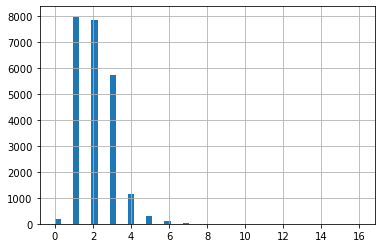

In [201]:
data['rooms'].hist(bins=50)

In [202]:
print(data.query('rooms ==7'))

       total_images  last_price  total_area first_day_exposition  rooms  \
581              20    65000000       365.0           2019-03-18      7   
681              20    24900000       249.0           2015-08-13      7   
750               9    29500000       188.8           2017-03-04      7   
855              18    15000000       134.0           2017-10-27      7   
1813              0    15000000       179.0           2017-04-09      7   
1943             20    16000000       184.4           2018-10-21      7   
2039              3    13520000       162.8           2018-03-21      7   
2261             15    17800000       164.0           2019-02-12      7   
2462             18     7900000       201.5           2018-08-17      7   
2673             11    16600000       214.0           2017-05-11      7   
3117             19   140000000       631.0           2019-03-30      7   
3315              6    16250000       210.4           2019-04-08      7   
3365             13    22

Данные для квартир с 7 комнатами выглядят правдоподобно, исходя из их общей площади. Такие квартиры располагаются в основном в Санкт-Петербурге и лишь одна в поселке Парголово

<AxesSubplot:>

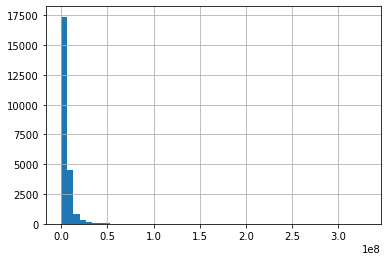

In [203]:
data['last_price'].hist(bins=50)

<div class="alert alert-block alert-success">
    
## Промежуточный вывод 

На этапе предобработки данных было сделано следующее:
Пропуски, там, где это возможно, были заменены на соответствующие значения:
- в 'balcony', 'parks_around3000' и 'ponds_around3000' пропуски были заменены на 0, так как данные числовые значения пользователи просто не указывали ввиду отсутствия у квартир данных атрибутов;
- parks_nearest и в ponds_nearest оставлены пропущенные значения, так как данные пропуски характеризуют отсутствие парков и водоемов поблизости;
- были изменены типы данных там, где это требовалось: 'first_day_exposition' был приведен к формату даты, числовые значения last_price приведены к типу ‘int32’ и создан столбец ‘last_price2’ с округленными до тысяч значениями.

На данном этапе были изучены уникальные значения в столбце с названиями населенных пунктов и устранены неявные дубликаты
Высота потолков 'ceiling_height' была обработана более глубоко: убраны редкие выбросы, данные приведены в соответствие нормам СанПина по высоте потолков, ими же заполнены пропуски согласно медианным значениям по населенным пунктам. Ошибки в заполнении данных были обработаны и приведены к десятичным числам.

Работа проведена также со значениями столбца ‘living_area’ – жилая площадь. В нем было достаточно много пропусков, скорее всего связанных банально с незаполнением пользователями и заполнены нами, исходя из медианной пропорции жилой площади к общей площади.
Пропуски в названиях населенных пунктов 'locality_name'– это или техническая ошибка, или отсутсвие из-за пользователей. Имя пропускам присвоено – ‘unknown’.
        
Пропуски в расстоянии до аэропорта 'airports_nearest' и в расстоянии до центра 'cityCenters_nearest' также связаны с тем, что их не указывали при размещении объявления. Заполнили мы их медианой данных атрибутов по конкретным населенным пунктам.
В данных по количеству комнат были несколько выбивающихся значений, которые, скорее всего произошли по технической ошибке.


# Шаг 3. Добавим в таблицу новые столбцы со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [204]:
data['1_meter_price'] = data['last_price'] / data['total_area']
data['weekday'] = data['first_day_rounded'].dt.weekday
data['month_of_exposition'] = data['first_day_rounded'].dt.month
data['year_of_exposition'] = data['first_day_rounded'].dt.year


In [205]:
# Для добавления столбца с типом этажа, создадим функцию с циклом:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [206]:
# применим созданную функцию к датасету
data['floor_type'] = data.apply(floor_type, axis=1)

In [207]:
print(data['floor_type'].head())

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floor_type, dtype: object


In [208]:
# расстояние до центра города в километрах
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000, 0)

# Шаг 4. Исследовательский анализ данных (EDA)

## 4.1.	Изучим следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.


In [209]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_th,1_meter_price,weekday,month_of_exposition,year_of_exposition,cityCenters_nearest_km
count,23373.000000,2.337300e+04,23373.000000,23373.000000,23217.000000,23287.000000,23373.000000,23373.000000,21121.000000,23373.000000,...,7878.000000,23373.000000,8922.000000,20251.000000,23373.000000,2.337300e+04,23373.000000,23373.000000,23373.000000,17962.000000
mean,9.847688,6.277348e+06,59.489117,2.056048,2.693084,10.728776,34.031911,5.913918,10.478155,0.593163,...,491.780147,0.584606,519.184824,180.238359,6277.331579,9.871185e+04,2.570530,6.399778,2017.368459,14.325855
std,5.669138,7.834678e+06,31.959427,1.046305,0.186356,6.602611,20.096903,4.897245,5.627228,0.960061,...,343.760604,0.878702,277.289266,219.229875,7834.670944,4.691037e+04,1.789364,3.489995,1.039541,8.613133
min,0.000000,1.219000e+04,12.000000,0.000000,2.500000,1.000000,7.375000,1.000000,1.300000,0.000000,...,1.000000,0.000000,13.000000,1.000000,12.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,7.000000,0.000000,...,288.000000,0.000000,295.000000,45.000000,3400.000000,7.650862e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,...,454.000000,0.000000,503.000000,95.000000,4600.000000,9.482759e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.700000,16.000000,42.000000,8.000000,12.000000,1.000000,...,613.000000,1.000000,732.000000,230.000000,6700.000000,1.138596e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,3.300000e+08,631.000000,16.000000,3.600000,60.000000,357.971154,33.000000,107.000000,5.000000,...,3190.000000,3.000000,1344.000000,1580.000000,330000.000000,1.736842e+06,6.000000,12.000000,2019.000000,66.000000


<AxesSubplot:title={'center':'Общая площадь'}, ylabel='Frequency'>

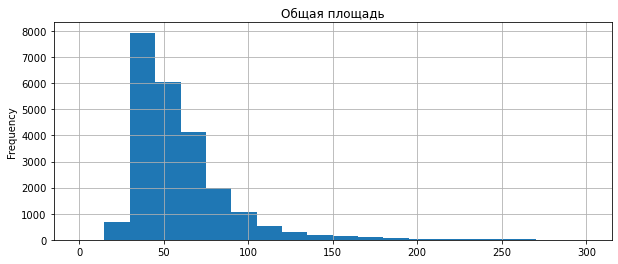

In [210]:
data['total_area'].plot(kind='hist', range=(0,300), bins=20, title='Общая площадь', grid=True, figsize=(10,4))

График распределения общей площади похож на распределение Пуассона

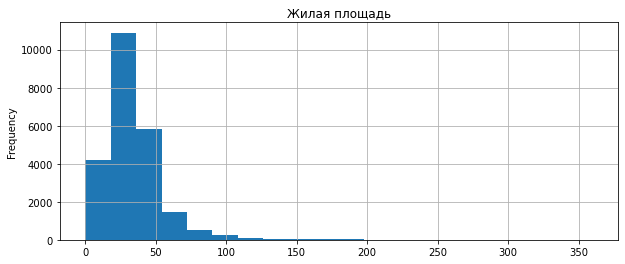

In [211]:
data['living_area'].plot(kind='hist', range=(0,360), bins=20, title='Жилая площадь', grid=True, figsize=(10,4));

График жилой площади также имеет Пуассоновское распределение, достигая максимума по количеству квртир на 40-45 метрах жилой площади

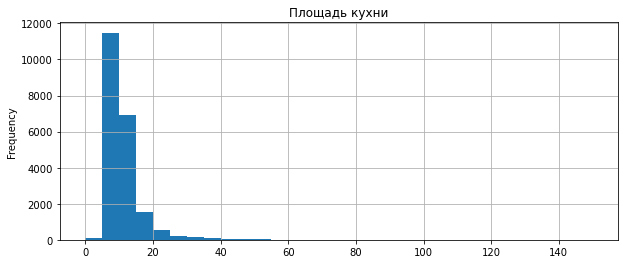

In [212]:
data['kitchen_area'].plot(kind='hist', range=(0,150), bins=30, title='Площадь кухни', grid=True, figsize=(10,4)); 

Площадь кухни имеет распределение Пуассона. Большинство кухонь не превышает 20 кв.м., максимизируясь по количеству на отметке в 10 кв.м.

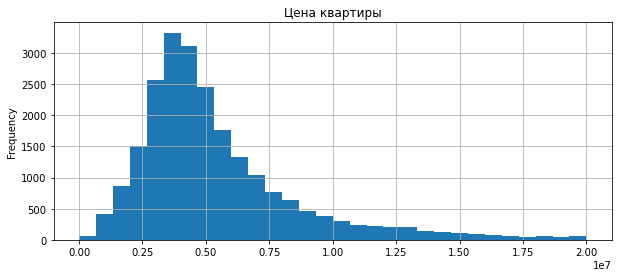

In [213]:
data['last_price'].plot(kind='hist', range=(0,2e+07), bins=30, title='Цена квартиры', grid=True, figsize=(10,4));

График стоимости квартир имеет распределение, близкое к распределению Гаусса, т.к. имеет форму колокола и симметрично распределяется до определенного момента справа. Справа же данные распределяются более размеренно, что говорит о довольно большом количестве дорогостоящик квартир

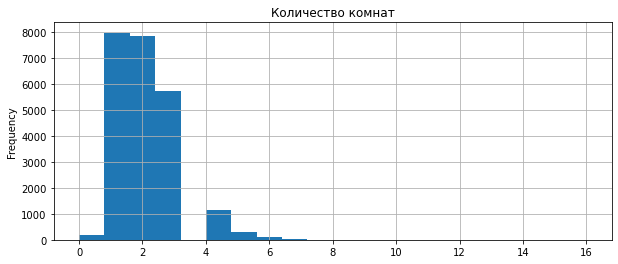

In [214]:

data['rooms'].plot(kind='hist', bins=20, title='Количество комнат', grid=True, figsize=(10,4)); 

Подавляющее число квартир в выборке имеет 1, 2 и 3 комнаты. Не имеющие комнат(студии) и имеющии свыше четырех - редкие элементы в выборке. Распределение Пуассона

<AxesSubplot:title={'center':'Высота потолков'}, ylabel='Frequency'>

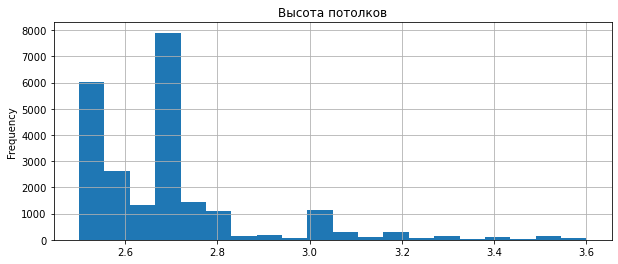

In [215]:
data['ceiling_height'].plot(kind='hist', bins=20, title='Высота потолков', grid=True, figsize=(10,4))

Высота потолков большинства квартир равна 2.7 метра, основная часть имеет высоту от 2.5 до 2.8 м. Следующий отличительный пик приходится на квартиры с высотой потолков 3 метра

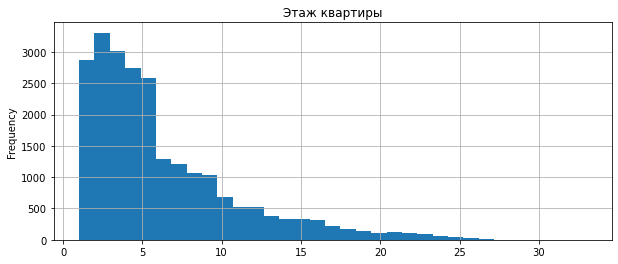

In [221]:
data['floor'].plot(kind='hist', bins=data['floor'].max(), title = 'Этаж квартиры', grid=True, figsize=(10,4)); 

Основная часть квартир располагается на 1-5 этажах, пик приходится на 2 этаж. Имеем классическое распределение Пуассона. Возможно, крупная часть датасета приходится на квартиры в пятиэтажных домах.
Также заметное снижение количества объявлений идет после 9 этажа, значит - много девятиэтажек

<AxesSubplot:>

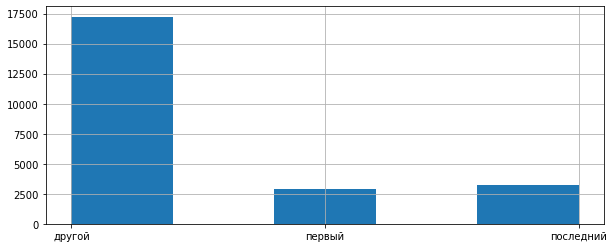

In [222]:
data['floor_type'].hist(bins=5, grid=True,figsize=(10,4))


In [223]:
fl_type = data['floor_type'].value_counts()

In [224]:
print(fl_type)

другой       17240
последний     3258
первый        2875
Name: floor_type, dtype: int64


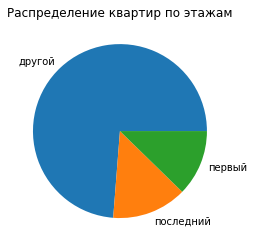

In [225]:
plt.pie(fl_type.values, labels = fl_type.index)
plt.title('Распределение квартир по этажам')
plt.show()

**Меньше всего представлено объявлений на 1 этаже, чуть больше - на последнем этаже, а вся основная масса сосредоточена на других этажах домов.**

<AxesSubplot:title={'center':'Количество этажей в домах'}, ylabel='Frequency'>

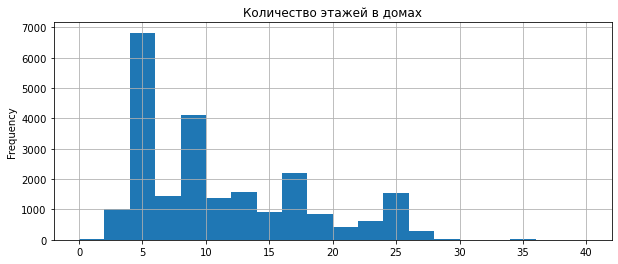

In [226]:
data['floors_total'].plot(kind='hist', bins=20, title='Количество этажей в домах', grid=True,range=(0,40), figsize=(10,4))

Предыдущий вывод подтверждается данным графиком: большинство домов - пятиэтажные, следующие по численности - девятиэтажные, затем по популярности идут дома до 14 включительно этажей и 18 этажей. Домов с этажностью свыше 18 немного. 

<AxesSubplot:title={'center':'Расстояние до центра города, м'}, ylabel='Frequency'>

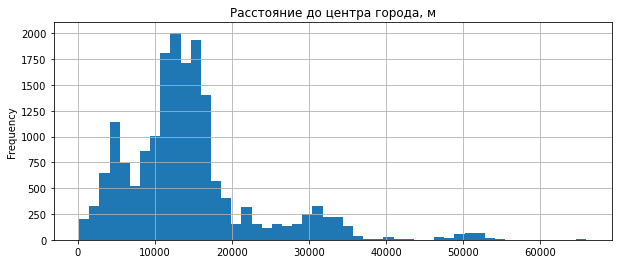

In [227]:
data['cityCenters_nearest'].plot(kind='hist', bins=50, title='Расстояние до центра города, м', grid=True, figsize=(10,4))

По расстоянию до ближайшего центра города выборка неравномерна. График имеет сходство с распределением Гаусса, но у нас есть пик на 5-6 тыс.м. Основные пики графика приходятся на 12 и 15 тыс.м. Часть квартир удалена от городского центра на 20 и более километров, имея очередной пик на 33 тыс.м. и доходя до 70 тыс.м.

<AxesSubplot:title={'center':'Расстояние до центра города, м'}, ylabel='Frequency'>

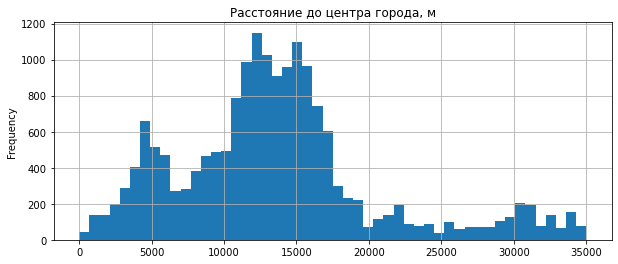

In [228]:
data['cityCenters_nearest'].plot(kind='hist', bins=50, title='Расстояние до центра города, м', grid=True, range=(0,35000), figsize=(10,4))

<AxesSubplot:title={'center':'Расстояние до ближайшего аэропорта, м'}, ylabel='Frequency'>

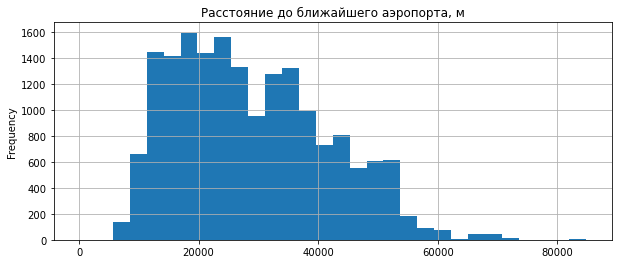

In [229]:
data['airports_nearest'].plot(kind='hist', bins=30, title='Расстояние до ближайшего аэропорта, м', grid=True, figsize=(10,4))

Пик значений приходится на 18-20 тыс.м. до ближайшего аэропорта.
Левая часть графика распределений значений расстояния до ближайшего аэропорта имеет схожесть с распределением Пуассона, тогда как правая - с распределением Гаусса

<AxesSubplot:title={'center':'Расстояние до ближайшего парка, м'}, ylabel='Frequency'>

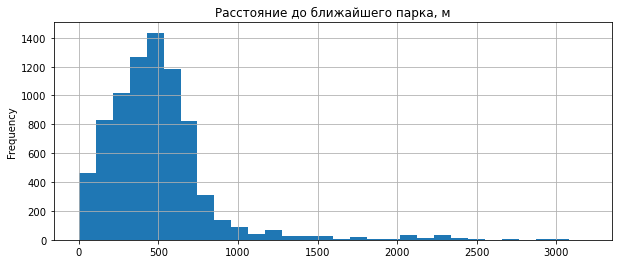

In [230]:
data['parks_nearest'].plot(kind='hist', bins=30, title='Расстояние до ближайшего парка, м', grid=True, figsize=(10,4))

<AxesSubplot:title={'center':'Расстояние до ближайшего парка, м'}, ylabel='Frequency'>

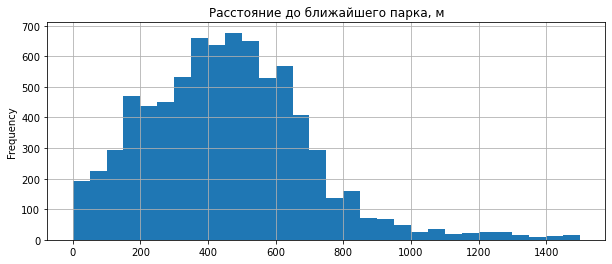

In [231]:
data['parks_nearest'].plot(kind='hist', bins=30, title='Расстояние до ближайшего парка, м', grid=True, range=(0,1500),figsize=(10,4))

График значений расстояния до ближайшего парка показывает нормальное распределение значений. Пик приходится на 500 м. 

<AxesSubplot:title={'center':'Месяц публикации объявления'}, ylabel='Frequency'>

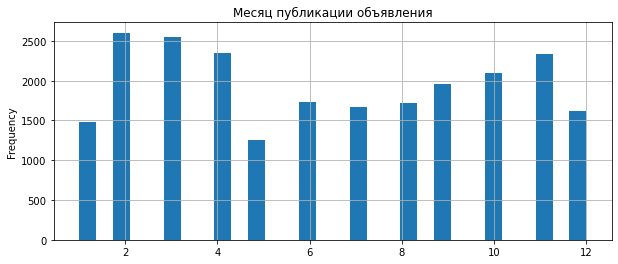

In [232]:
data['month_of_exposition'].plot(kind='hist', bins=30, title='Месяц публикации объявления', grid=True, figsize=(10,4))

**Публикации объявлений происходили неравномерно и не прослеживается явной зависимости количества объявлений от месяца года.**

<AxesSubplot:title={'center':'Год публикации объявления'}, ylabel='Frequency'>

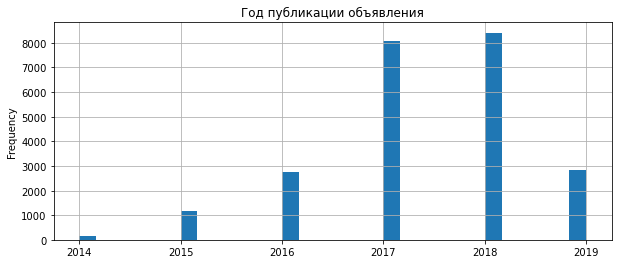

In [233]:
data['year_of_exposition'].plot(kind='hist', bins=30, title='Год публикации объявления', grid=True, figsize=(10,4))

**Максимум объявлений о продаже квартир пришелся на 2017-2018 годы.**

**Распределение публикации объявлений по дням:**

<AxesSubplot:title={'center':'День публикации объявления'}, ylabel='Frequency'>

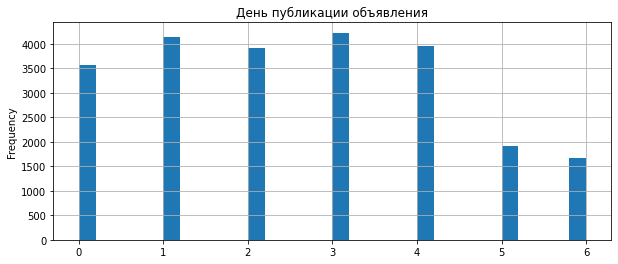

In [304]:
data['weekday'].plot(kind='hist', bins=30, title='День публикации объявления', grid=True, figsize=(10,4))

<div class="alert alert-block alert-warning">
Заметим, что меньше всего объявлений публиковалось в выходные дни. Возможно, люди отдыхали, а возможно - по выходным (в свое свободное время) составляли тексты и содержание объявлений, а в будни публиковали. 

## 4.2.	Изучим, как быстро продавались квартиры 

In [234]:
data['days_exposition'].describe()

count    20251.000000
mean       180.238359
std        219.229875
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [235]:
print('Среднее количество дней ', data['days_exposition'].mean())
print('Медиана коичества дней', data['days_exposition'].median())

Среднее количество дней  180.23835859957532
Медиана коичества дней 95.0


<div class="alert alert-block alert-warning">
Медиана довольно существенно отличается от среднего: среднее количество дней продажи равно 180 дням, тогда как 50% выборки не превышает 95 дней. Сандартное отклонение указывает на большой разброс в данных. Максимальное количество дней равняется 1580, что больше 4-х лет.
Можем считать, что быстрая продажа - это продажа в течение 95 дней, а необычно долгая продажа - свыше 180 дней.

<AxesSubplot:title={'center':'Кол-во дней размещения объявлений'}, ylabel='Frequency'>

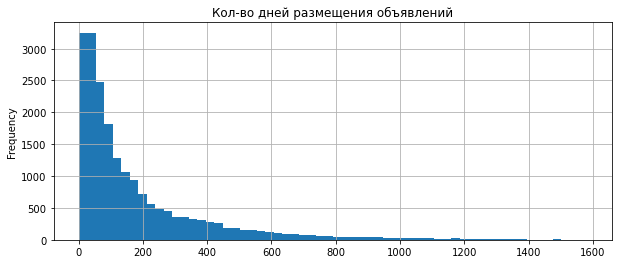

In [236]:
data['days_exposition'].plot(kind='hist', bins=60, title='Кол-во дней размещения объявлений', grid=True, figsize=(10,4))

Мы имеем классическое распределение Пуассона

<AxesSubplot:title={'center':'Кол-во дней размещения объявлений'}, ylabel='Frequency'>

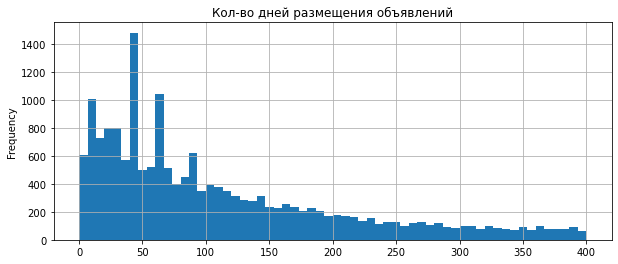

In [237]:
data['days_exposition'].plot(kind='hist', bins=60, title='Кол-во дней размещения объявлений', grid=True, range = (0,400),figsize=(10,4))

**Пики отмечаются на показателях: 13 дней, 45 дней, 66 дней, 95 дней.**
Возможная причина пиков - в эти дни система убирает с показа бесплатные объявления. 



## 4.3. Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта

**Факторы, сильно влияющие на полную стоимость объекта:**
- общая площади;
- жилая площади;
- площадь кухни;
- количество комнат;
- этаж, на котором расположена квартира (первый, последний, другой);
- дата размещения (день недели, месяц, год).


**Рассмотрим зависимость общей площади и стоимости квартир:**

In [238]:
#вычислим коэффициент корреляции Пирсона для стоимости объекта и общей площади
print('Коэффициент корреляции Пирсона полной стоимости и общей площади:', data['last_price'].corr(data['total_area']))

Коэффициент корреляции Пирсона полной стоимости и общей площади: 0.6870076311724073


**Коэффициент близится к 0.7, что говорит о наличии достаточно сильной прямой связи.**

<AxesSubplot:xlabel='last_price_th', ylabel='total_area'>

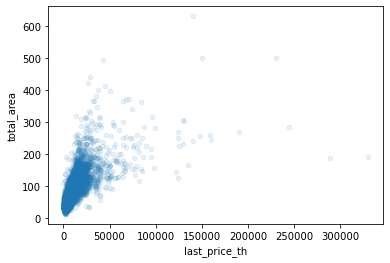

In [239]:
data.plot(x='last_price_th', y='total_area', kind='scatter', alpha=0.1)

**Основная часть графика показывает возрастающее значение цены при возрастании общей площади. Но также есть случаи, когда при очень большой площади цена меньше, чем при аналогичных значениях площади в других объявлениях. Или наоборот - есть квартиры, стоимостью свыше 200 млн.р.,но с площадью меньшей, чем для квартир с меньшей стоимостью.**

**Рассмотрим зависимость жилой площади и стоимости квартир:**

In [240]:
print('Коэффициент корреляции Пирсона полной стоимости и жилой площади:', data['last_price'].corr(data['living_area']))

Коэффициент корреляции Пирсона полной стоимости и жилой площади: 0.609446080516867


**Коэффициент говорит о наличии прямой умеренной связи.**

<AxesSubplot:xlabel='last_price_th', ylabel='living_area'>

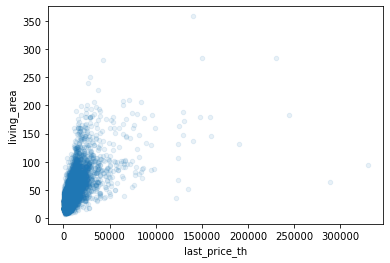

In [242]:
data.plot(x='last_price_th', y='living_area', kind='scatter', alpha=0.1)

Мы также видим восходящую тенденцию основной массы квартир: чем выше жилая площадь, тем выше стоимость квартиры. При этом у нас также есть выбивающиеся значения квартир с меньшей жилой площадью и большей стоимостью

**Рассмотрим зависимость площади кухни и стоимости квартир:**

In [243]:
print('Коэффициент корреляции Пирсона полной стоимости и площади кухни:', data['last_price'].corr(data['kitchen_area']))

Коэффициент корреляции Пирсона полной стоимости и площади кухни: 0.5199019978543711


**Есть положительная слабая зависимость.**

<AxesSubplot:title={'center':'Зависимость площади кухни и стоимости квартир'}, xlabel='last_price_th', ylabel='kitchen_area'>

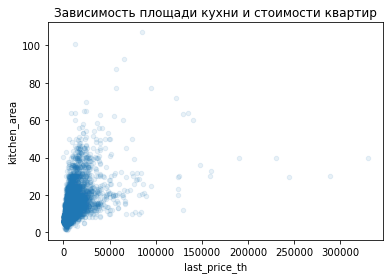

In [244]:
data.plot(x='last_price_th', y='kitchen_area', kind='scatter', alpha=0.1, title='Зависимость площади кухни и стоимости квартир')

Диаграмма рассеяния подтвержает вывод коэффициента корреляции. На графике видна иная тенденция, нежели в предыдущих случаях: при росте площади кухни происходит лишь незначительный рост стоимости квартиры

**Рассмотрим зависимость количества комнат и стоимости квартир:**

In [245]:
print('Коэффициент корреляции Пирсона полной стоимости и количества комнат:', data['last_price'].corr(data['rooms']))

Коэффициент корреляции Пирсона полной стоимости и количества комнат: 0.39193477047280273


**Коэффициент говорит нам о наличии слабой положительной связи: то есть при увеличении количества комнат, стоимость квартиры лишь незначительно возрастает в 1.39 раза.**

<AxesSubplot:title={'center':'Зависимость количества комнат и стоимости квартир'}, xlabel='last_price_th', ylabel='rooms'>

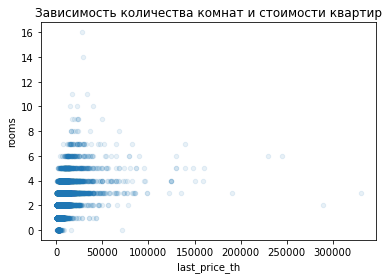

In [246]:
data.plot(x='last_price_th', y='rooms', kind='scatter', alpha=0.1, title='Зависимость количества комнат и стоимости квартир')

Вывод выше нам подтвержает и диаграмма рассеяния. При чем мы видим разделение квартир на ниши: каждая ниша - квартиры  определенным количеством комнат, цена на которую плавно возрастает до определенного значения цены.

**Рассмотрим зависимость типа этажа и стоимости квартир:**

Коэффициент корреляции для числового и строкового значения мы вычислить не можем, поэтому пойдем другим путём. Рассчитаем медианные значения цены для типов этажей:

In [247]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median')

,last_price
floor_type,
другой,4800000
первый,3900000
последний,4300000


**Квартиры на первом этаже пользуюся наименьшим спросом.**

Создадим дополнительный столбец с числовыми значениями типов этажей floor_type2, где 1 - первый этаж, 0 - последний, 2 - другой

In [248]:
# Для добавления столбца с типом этажа, создадим функцию с циклом:
def floor_type2(row):
    if row['floor_type'] == 'первый':
        return 1
    elif row['floor_type'] == 'последний':
        return 0
    else:
        return 2

In [249]:
data['floor_type2'] = data.apply(floor_type2, axis=1)

In [250]:
print('Коэффициент корреляции Пирсона полной стоимости и типа этажа:', data['last_price'].corr(data['floor_type2']))

Коэффициент корреляции Пирсона полной стоимости и типа этажа: 0.02624824097045761


**Коэффициент показывает, что зависимости нет.**

<AxesSubplot:title={'center':'Зависимость типа этажа и стоимости квартир'}, xlabel='last_price_th', ylabel='floor_type2'>

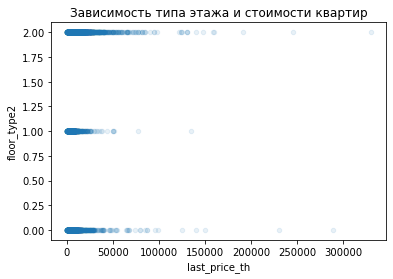

In [251]:
data.plot(x='last_price_th', y='floor_type2', kind='scatter', alpha=0.1, title='Зависимость типа этажа и стоимости квартир')

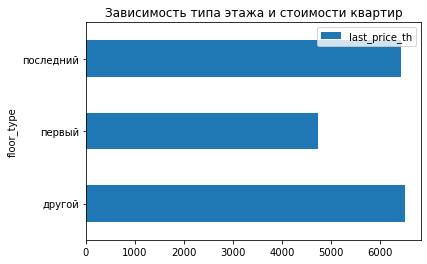

In [252]:
data.pivot_table(index='floor_type',values='last_price_th').plot(y='last_price_th', kind='barh', title = 'Зависимость типа этажа и стоимости квартир');

На графиках видно, что квартиры с самой низкой стоимостью расположены на первых этажах. На диаграмме рассеяния заметно, что квартир с высокой стоимостью больше на этажах типа 'другой'

**Рассмотрим зависимость даты размещений и стоимости квартир**

<function matplotlib.pyplot.show(close=None, block=None)>

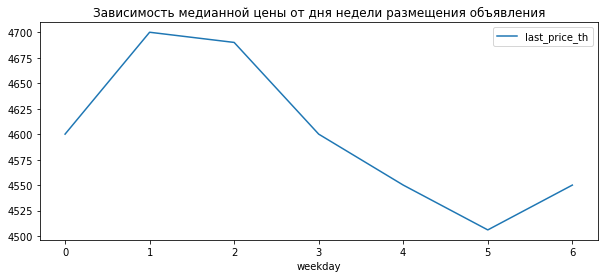

In [254]:
data.pivot_table(index='weekday', values='last_price_th', aggfunc = 'median')\
.plot(style='-',title='Зависимость медианной цены от дня недели размещения объявления', figsize=(10,4))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

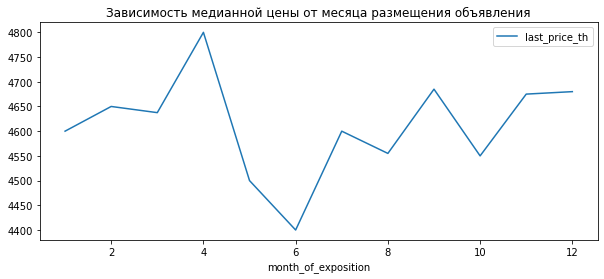

In [255]:
data.pivot_table(index='month_of_exposition', values='last_price_th', aggfunc = 'median')\
.plot(style='-',title='Зависимость медианной цены от месяца размещения объявления', figsize=(10,4))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

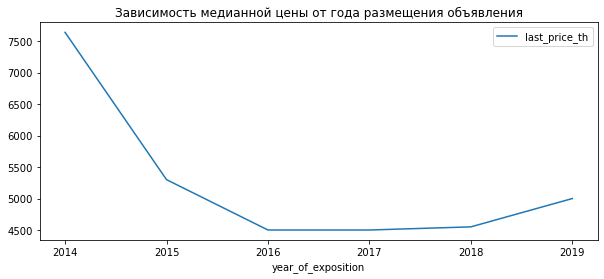

In [256]:
data.pivot_table(index='year_of_exposition', values='last_price_th', aggfunc = 'median')\
.plot(style='-',title='Зависимость медианной цены от года размещения объявления', figsize=(10,4))
plt.show

<div class="alert alert-block alert-success">

Графики сообщают об отсутствиии зависимости даты публикации и стоимости квартир. Самые высокие цены фиксируются во вторник, в апреле и в 2014 году. Но также заметим, что снижение цен происходит в выходные дни.

Не прослеживается и сезонности роста цены объявлений. 

Высокая стоимость недвижимости в 2014 году, возможно, связана с малым количеством объявлений на сервисе, ведь их развитие (сервисов объявлений о продаже недвижимости) было тогда на начальном уровне. С развитием сервисов, росте количества онлайн-объявлений, росте конкуренции, медианные цены стали снижаться.
А может это связано с экономическим кризисом 2014 года.

**Посмотрим график зависимости средней цены от дня недели размещения объявления**

<function matplotlib.pyplot.show(close=None, block=None)>

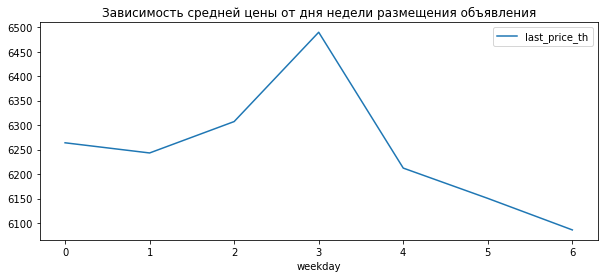

In [257]:
data.pivot_table(index='weekday', values='last_price_th')\
.plot(style='-',title='Зависимость средней цены от дня недели размещения объявления', figsize=(10,4))
plt.show

Зависимости нет. Самые дорогие квартиры опубликованы в четверг, а самая низкая стоимость зафиксирована в воскресенье

**График зависимости средней цены от месяца размещения объявления**

<function matplotlib.pyplot.show(close=None, block=None)>

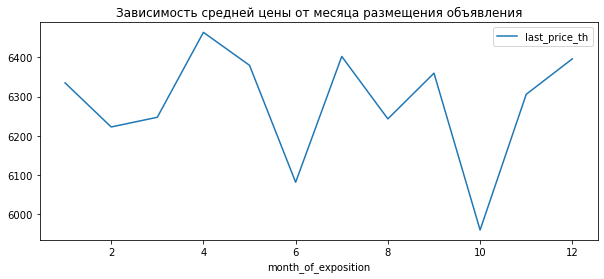

In [258]:
data.pivot_table(index='month_of_exposition', values='last_price_th')\
.plot(style='-',title='Зависимость средней цены от месяца размещения объявления', figsize=(10,4))
plt.show

Самые низкие цены зафиксированы в июне и ноябре, а самые высокие - в апреле, июле и декабре. График также подтвержает отсутствие зависимости

**График зависимости средней цены от года размещения объявления**

<function matplotlib.pyplot.show(close=None, block=None)>

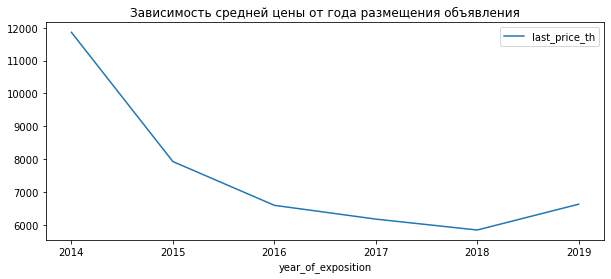

In [259]:
data.pivot_table(index='year_of_exposition', values='last_price_th')\
.plot(style='-',title='Зависимость средней цены от года размещения объявления', figsize=(10,4))
plt.show

<div class="alert alert-block alert-warning">
На графике мы видим отрицательную динамику цен. Самые высокие средние цены зафиксированы в 2014 году, самые низкие - в 2018. Но, возможно, это связано с тем, что публикаций объявлений о продаже квартир в электронном виде стало больше, они стали более неоднородными и затрагивают различные сегменты

## 4.4.	Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [260]:
#Помимо средней цены посчитаем и медиану
top10_locality =  data.pivot_table(index='locality_name2', values='1_meter_price', aggfunc=['count', 'mean', 'median']).sort_values(('count', '1_meter_price'), ascending=False)\
.head(10).sort_values(('mean', '1_meter_price'), ascending=False)
top10_locality.columns=['locality_count','1_meter_price_mean','1_meter_price_median']

In [261]:
print(top10_locality)

                   locality_count  1_meter_price_mean  1_meter_price_median
locality_name2                                                             
санкт-петербург             15462       113908.303367         104615.384615
пушкин                        360       102596.424446          99865.712506
деревня кудрово               299        92473.547576          91860.465116
поселок парголово             326        90205.423758          91780.224134
поселок мурино                555        85653.613799          85714.285714
поселок шушары                438        78681.010418          76876.172608
колпино                       337        75443.972838          74725.274725
гатчина                       306        68799.627791          67860.569236
всеволожск                    395        68617.058829          65789.473684
выборг                        231        58189.318417          58158.319871


<AxesSubplot:title={'center':'Топ 10 населенных пунктов по стоимости 1 кв.м.'}, xlabel='locality_name2'>

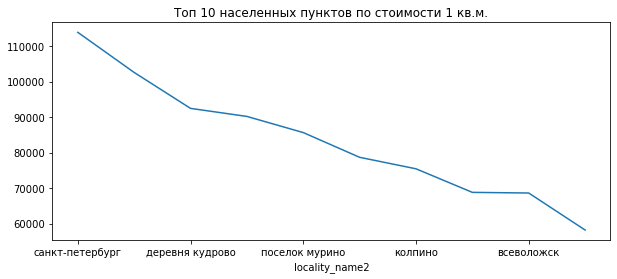

In [262]:
top10_locality['1_meter_price_mean'].plot(style='-', title='Топ 10 населенных пунктов по стоимости 1 кв.м.', figsize=(10,4))

Населенный пункт с самой высокой стоимостью квадратного метра: Санкт-Петербург

Населенный пункт с самой низкой стоимостью квадратного метра: Выборг

Для сравнения можем поссмотреть, как зависит стоимость квадратного метра от расстояния до центра города

In [263]:
top10_locality2 =  data.pivot_table(index='locality_name2', values=['1_meter_price','cityCenters_nearest_km'], aggfunc=['count', 'mean']).sort_values(('count', 'cityCenters_nearest_km'), ascending=False)\
.head(10).sort_values(('mean', 'cityCenters_nearest_km'), ascending=False)

In [264]:
print(top10_locality2)

                          count                                  mean  \
                  1_meter_price cityCenters_nearest_km  1_meter_price   
locality_name2                                                          
ломоносов                   132                    132   72672.673607   
кронштадт                    93                     93   79860.123222   
петергоф                    201                    201   84757.559690   
сестрорецк                  181                    181  101332.759365   
колпино                     337                    337   75443.972838   
красное село                176                    176   71966.488148   
пушкин                      360                    360  102596.424446   
поселок шушары              438                    438   78681.010418   
поселок парголово           326                    326   90205.423758   
санкт-петербург           15462                  15402  113908.303367   

                                          
       

<AxesSubplot:title={'center':'Топ 10 населенных пунктов по стоимости 1 кв.м.'}, xlabel='locality_name2'>

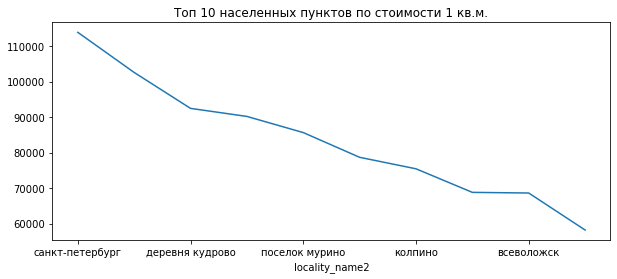

In [265]:
top10_locality['1_meter_price_mean'].plot(style='-', title='Топ 10 населенных пунктов по стоимости 1 кв.м.', figsize=(10,4))

А вот тут мы не видим явной зависимости, что чем ближе к центру, тем дороже квадратный метр. Логично, что в Санкт-Петербурге цена за квадратный метр выше, и расстояние до центра меньше. При этом следующим по стоимости за кв.м. стоят города Пушкин и Сестрорецк, которые по расстоянию до центра стоят на 4 и 7 местах соответственно.

## 4.5.	Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра. Посмотрим, как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:title={'center':'Средняя цена каждого километра в Санкт-Петербурге'}, xlabel='cityCenters_nearest_km'>

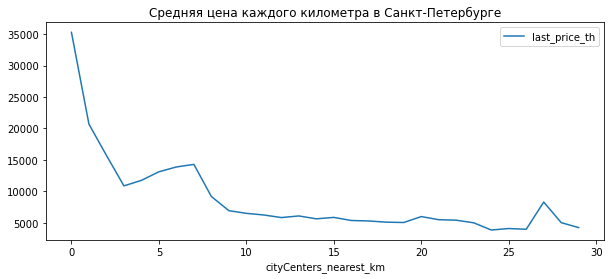

In [266]:
data[data['locality_name2']=='санкт-петербург'].pivot_table(index='cityCenters_nearest_km', values='last_price_th')\
.plot(style='-', title='Средняя цена каждого километра в Санкт-Петербурге', figsize=(10,4))

<div class="alert alert-block alert-success">
Чем дальше от центра Санкт-Петербурга - тем дешевле квартиры. На расстоянии 0-1 км стоимость квартир достигает своего максимума в 30-35 млн.р. Тенденция продолжается до 3 км от центра. Есть несколько показателей, которые выбиваются из данного правила: с 3 по 8 км видится увеличение стоимости. Также подобное прослеживается на расстоянии 26-28 км от центра - на этом участке цены выше тех,  к которым стремится тенденция графика.

# Шаг 5. Общий вывод

Мы получили и проанализировали датасет с данными сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. Подавляющее число квартир в выборке имеет 1, 2 и 3 комнаты и расположены на этажах выше первого и ниже последнего. Самые непопулярные квартиры располагаются на 1 этаже.



Была проведена предобработка данных: скорректированы типы данных, пропуски в данных по количеству балконов, паркам и водоемам заполнены нулями. В parks_nearest и в ponds_nearest оставлены пропущенные значения. Пропущенные данные в столбце is_apartment были заменены на значение False. last_price привели к типу int, а также создали его дубликат  last_price2, который округлили до тысяч.

first_day_exposition -  мы привели данный (о дате публикации объявления) столбец в формат даты. В строках также не указаны часы и секунды - вместо них нули, поэтому был создан столбец first_day_rounded с округленными до дня датами

Мы избавились от неявных дубликатов в названиях населённых пунктов, при этом создав новый столбец 'locality_name2'. Провели проверку на явные дубликаты.

При обработке высоты потолков ceiling_height значения были приведены в соответствие нормам СанПина, где минимальная высота потолков достигает 2.5 метра: 
- высота потолков с двузначными значениями (от 25 до 36 м) предполагает опечатку, поэтому мы разделили на 10 и получили адекватные цифры - 2.5 и 3.6 метра соответственно;
- выбросы были удалены (Квартир с потолками ниже 2.5 м и выше 3.6 м не так много, поэтому мы посчитали их выбросами и удалили);
- остальные пропущенные значения высоты были заменены медианными значениями по соответствующему населенному пункту.

Рассматривая living_area - размер жилой площади - сделано следующее:
- удалены значения менее 10 и более 200 кв.м, их оказалось мало и мы посчитали их выбросами;
- пропуски living_area были заполнены, исходя из средней пропорции жилой площади к общей площади.

Информация по количеству балконов:
- однокомнатные и двухкомнатные квартиры не могут иметь 5 балконов, а тем более 7, мы их заполнили медианными значениями. 


Информация по пропускам в названии населенных пунктов:
- пропуски в названиях населенных пунков 'locality_name' были заполнены значением 'unknown'. В ином случае (при удалении) мы просто потеряли бы данные.

Пропуски в данных по расстоянию до ближайшего аэропорта:
- скорее всего пропуски связаны с тем, что данные по расстоянию до аэропорта просто не указали при размещении объявления. Пропуски были заполнены медианным значением для каждого населенного пункта
- замена на медианные значения была произведена по населенным пунктам, исключая Санкт-Петербург (там несколько аэропортов) и unknown (мы не знаем, какие это населенные пункты). Подобное произведено и с cityCenters_nearest

В датасет были добавлены новые столбцы:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах.

Большинство квартир представлены общей площадью от 30 до 75 кв.м. Стандартное отклонение значений равно 31.96, что говорит о большом разбросе данных. Это верно - в датасете представлены квартиры премиум класса с площадью от 150 кв.м., а также небольшие квартиры до 25 кв.м.

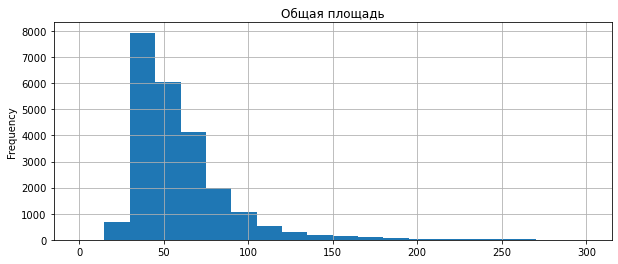

In [267]:
data['total_area'].plot(kind='hist', range=(0,300), bins=20, title='Общая площадь', grid=True, figsize=(10,4));

Жилая площадь схожа по характеристикам с общей площадью и имеет явное Пуассоновское распределение с длинным хвостом справа вплоть до 200 кв.м.

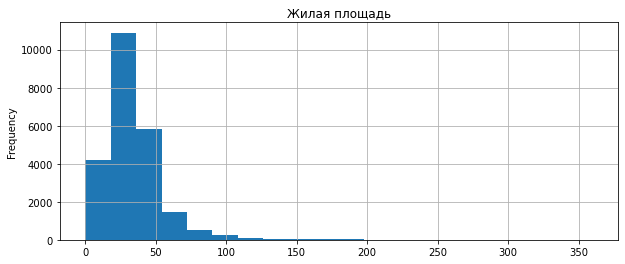

In [268]:
data['living_area'].plot(kind='hist', range=(0,360), bins=20, title='Жилая площадь', grid=True, figsize=(10,4));

Распределение цен на квартиры имеет форму Гауссовского колокола, то есть имеют нормальное распределение. Справа данные снижаются более размеренно, что говорит о довольно большом количестве дорогостоящик квартир. Максимум цены и количества объявлений достигается в районе 3.3 млн.р. 

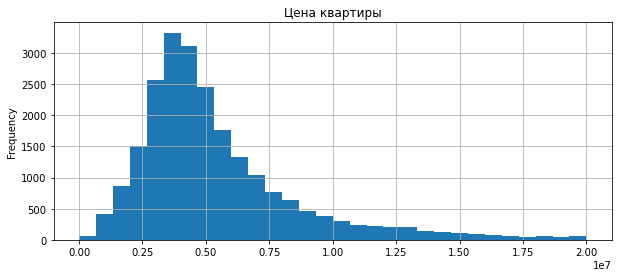

In [269]:
data['last_price'].plot(kind='hist', range=(0,2e+07), bins=30, title='Цена квартиры', grid=True, figsize=(10,4));

<div class="alert alert-block alert-warning">
При рассмотрении этажности домов оказалось, что большинство из них - это пятиэтажные постройки. Далее пик приходится на 9-ти этажные дома. 

<AxesSubplot:title={'center':'Количество этажей в домах'}, ylabel='Frequency'>

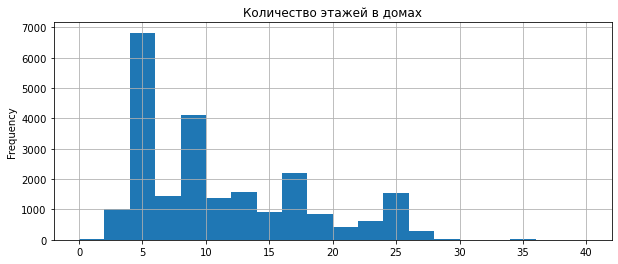

In [270]:
data['floors_total'].plot(kind='hist', bins=20, title='Количество этажей в домах', grid=True,range=(0,40), figsize=(10,4))

Основная часть квартир располагается на 1-5 этажах, пик приходится на 2 этаж. Имеем классическое распределение Пуассона. Возможно, крупная часть датасета приходится на квартиры в пятиэтажных домах. Также заметное снижение количества объявлений идет после 9 этажа, значит - много девятиэтажек

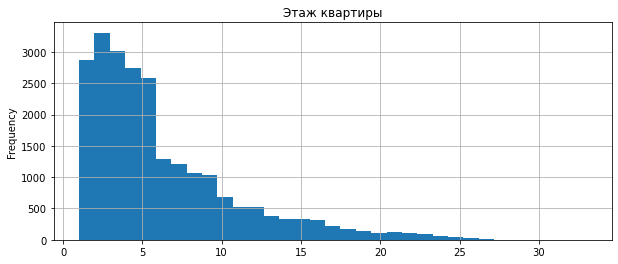

In [271]:
data['floor'].plot(kind='hist', bins=data['floor'].max(), title='Этаж квартиры', grid=True, figsize=(10,4)); 

**При анализе факторов, которые могут оказывать влияние на стоимость квартиры, обнаружилось следующее:**
- Выявлена прямая и достаточно сильная зависимость стоимости жилого объекта от общей площади - чем больше площадь, тем выше стоимость;
- Прямая зависимость также прослеживается между стоимостью и размером жилой площади;
- Есть положительная, но слабая зависимость между стоимостью квартиры и площадью кухни;
- Слабое положительное влияние на стоимость объекта оказывает количество комнат;
- Тип этажа квартиры, дата размещения объявления на прямую не влияют на стоимость квартир.

**Топ-10 населенных пунктов по числу объявлений:**
- Санкт-Петербург
- Пушкин
- деревня Кудрово
- поселок Парголово
- поселок Мурино
- поселок Шушары
- Колпино
- Гатчина
- Всеволожск
- Выборг

Самая высокая цена за кв.м. - в Санкт-Петербурге: 113908.3 руб, самая низкая цена за кв.м. - в Выборге: 58189.31 руб.

**При анализе объектов в Санкт-Петербурге и их расположения относительно центра, выявлено следующее:**
Чем дальше от центра Санкт-Петербурга - тем дешевле квартиры. На расстоянии 0-1 км стоимость квартир достигает своего максимума в 30-35 млн.р. Тенденция продолжается до 3 км от центра. Есть несколько показателей, которые выбиваются из данного правила: с 3 по 8 км видится увеличение стоимости. Также подобное прослеживается на расстоянии 26-28 км от центра - на этом участке цены выше тех,  к которым стремится тенденция графика ниже.

<AxesSubplot:title={'center':'Средняя цена каждого километра в Санкт-Петербурге'}, xlabel='cityCenters_nearest_km'>

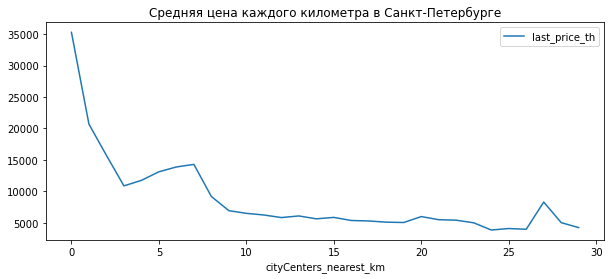

In [272]:
data[data['locality_name2']=='санкт-петербург'].pivot_table(index='cityCenters_nearest_km', values='last_price_th')\
.plot(style='-', title='Средняя цена каждого километра в Санкт-Петербурге', figsize=(10,4))